### Porto Seguro's Safe Driver Prediction (안전 운전자 예측 경진대회)
- 모델을 통해 운전자에게 합리적인 가격을 제공하고, 더 많은 운전자들이 자동차 보험의 혜택을 받을수 있게 함
- 문제 유형 : 이중 클래스 분류 / 평가 척도 : 정규화 지니 계수 : 0에 가까울수록, 예측 모델의 정확도가 낮고, 1에 가까울수록 성능이 좋음
- 운전자 A가 내년에 보험을 청구할 확률을 예측하는 경진대회
- 피처 엔지니어링이 핵심인 대회. 
- 결측값의 갯수를 기반으로 파생 변수를 생성하고 범주형 변수를 OneHotEncode하여 새로운 변수를 생성하고,
- 특정 변수 그룹을 문자열로 통합하여 변수 그룹 내 조합을 나타내는 새로운 변수를 생성함
- 인공신경망 모델과 LightGBM모델을 앙상블 수행시 큰 성능 개선을 보임.
- 전체 데이터에서 변수 고유값별 빈도 등의 기초 통계값을 파생 변수로도 사용
- 변수명 익명화

### EDA는 크게 두 가지 방법이 있다.
- (1) 기초 통계를 통하여 Raw Data를 분석하는 방법이나
- (2) 시각화를 통해 Raw Data를 분석하는 방법

In [2]:
import pandas as pd
import numpy as np

# 1-1. 훈련 데이터, 테스트 데이터 읽어오기.
# 훈련데이터는 59만개 / 테스트는 89만개
# 훈련데이터는 운전자의 보험 청구 여부를 나타내는 target변수 포함(59개). 테스트 데이터는 미포함(58개)
data_path = 'D:/dataset/porto-seguro-safe-driver-prediction/'
trn = pd.read_csv(data_path + 'train.csv', na_values=['-1','-1.0']) # na_values는 데이터중 에서 -1이나 -1.0을 결측값으로 처리해라
tst = pd.read_csv(data_path + 'test.csv', na_values=['-1','-1.0'])

print('데이터 로딩 완료')

# 데이터의 크기를 확인한다
print(trn.shape, tst.shape)

# 데이터 첫 5줄을 확인한다
trn.head()

# 데이터프레임에 대한 메타 정보를 확인한다
# _bin으로 끝나는 변수는 이진(binary)변수 / _cat으로 끝나는 변수는 범주형(categorical) 변수
trn.info()

데이터 로딩 완료
(595212, 59) (892816, 58)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     594996 non-null float64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595129 non-null float64
ps_ind_05_cat     589403 non-null float64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_re

##### ==> 데이터가 int64 또는 float64로 이루어짐을 알 수 있음.

In [3]:
# 1-2. 타겟 변수의 고유값과 타겟==1 의 비율을 계산 및 최대, 최솟값, 결측값 파악

print(np.unique(trn['target']))
print(1.0 * sum(trn['target'])/trn.shape[0])
print(sum(trn['target'])) # 595212

# 변수의 최댓값, 최솟값 등을 확인한다.
trn.describe()

# 결측값파악
trn.isnull().sum(axis=0) # (595212, 59)에서 axis=0은 595212, axis=1이면 59
tst.isnull().sum(axis=0) # (892816, 58)에서 axis=0은 892816, axis=1이면 58

[0 1]
0.036447517859182946
21694


id                     0
ps_ind_01              0
ps_ind_02_cat        307
ps_ind_03              0
ps_ind_04_cat        145
ps_ind_05_cat       8710
ps_ind_06_bin          0
ps_ind_07_bin          0
ps_ind_08_bin          0
ps_ind_09_bin          0
ps_ind_10_bin          0
ps_ind_11_bin          0
ps_ind_12_bin          0
ps_ind_13_bin          0
ps_ind_14              0
ps_ind_15              0
ps_ind_16_bin          0
ps_ind_17_bin          0
ps_ind_18_bin          0
ps_reg_01              0
ps_reg_02              0
ps_reg_03         161684
ps_car_01_cat        160
ps_car_02_cat          5
ps_car_03_cat     616911
ps_car_04_cat          0
ps_car_05_cat     400359
ps_car_06_cat          0
ps_car_07_cat      17331
ps_car_08_cat          0
ps_car_09_cat        877
ps_car_10_cat          0
ps_car_11_cat          0
ps_car_11              1
ps_car_12              0
ps_car_13              0
ps_car_14          63805
ps_car_15              0
ps_calc_01             0
ps_calc_02             0


##### ==> 즉 전체 595212중 21694명에게 보험청구를 하였다.
##### ==> 약 전체 데이터중 3.6%에게 운전자 보험 청구를 진행하였었음. -> 타겟변수가 1일 확률이 매우 낮은 불균형한 데이터임.

In [4]:
# 1-3. 훈련 데이터와 테스트 데이터를 통합한다.
# 148만개의 총 57개 그래프 생성

# test 데이터의 target 결측값으로 처리
tst['target']= np.nan  

# trn과 tst를 합침 concat함수
df = pd.concat([trn, tst], axis=0) 

C:\Users\Black\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [5]:
# 1-4. 시각화 관련 라이브러리를 불러온다,
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 시각화 관련 함수를 미리 정의한다.
def bar_plot(col, data, hue=None): # 각 열별 클래스 데이터가 몇개가 있는가
    f, ax=plt.subplots(figsize=(10,5))
    sns.countplot(x=col, hue=hue, data=data, alpha=0.5) # 각 열별 클래스 데이터가 몇개가 있는가
    plt.show()

def dist_plot(col, data):
    f, ax = plt.subplots(figsize=(10,5))
    sns.distplot(data[col].dropna(), kde=False, bins=10) # 각 열별 클래스데이터 밀도
    plt.show()

def bar_plot_ci(col, data):
    f, ax = plt.subplots(figsize=(10,5))
    sns.barplot(x=col, y='target', data=data)
    plt.show()

# 1-5. 분석의 편의를 위해 변수 유형별로 구분한다
# 이진, 범주형, 정수형, 소수형 4개의 그룹으로 나눌 수 있음
# 이진 변수 
binary = ['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
          'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_calc_15_bin', 
          'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin'] # 17개
# 범주형 변수
category = ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 
            'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 
            'ps_car_10_cat', 'ps_car_11_cat'] # 14개
# 정수형 변수
integer = ['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 
           'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 
           'ps_calc_14', 'ps_car_11'] # 16개
# 소수형 변수
floats = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_car_12', 'ps_car_13',
          'ps_car_14', 'ps_car_15'] # 10개

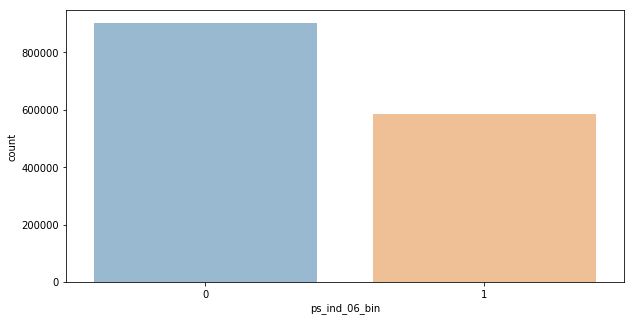

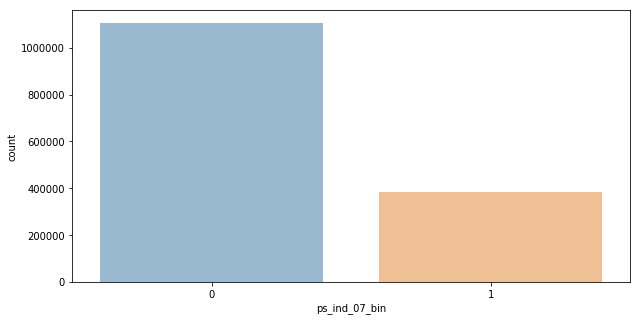

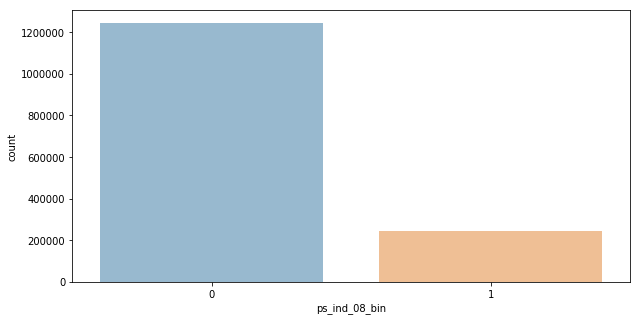

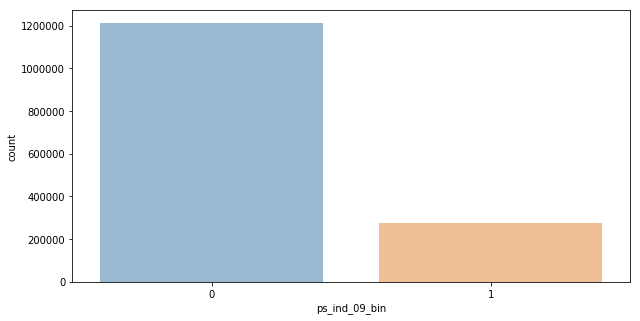

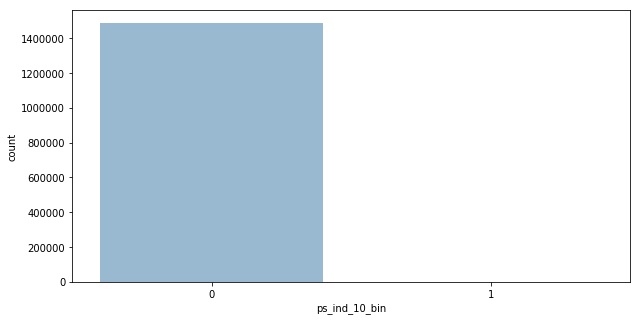

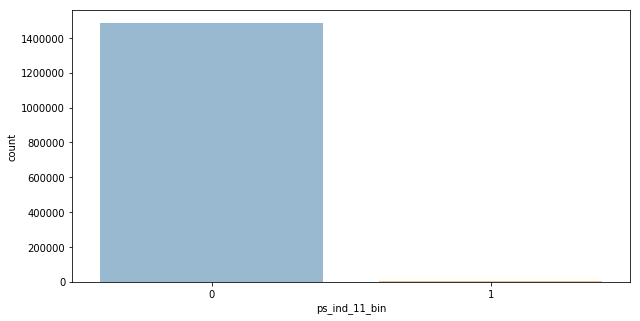

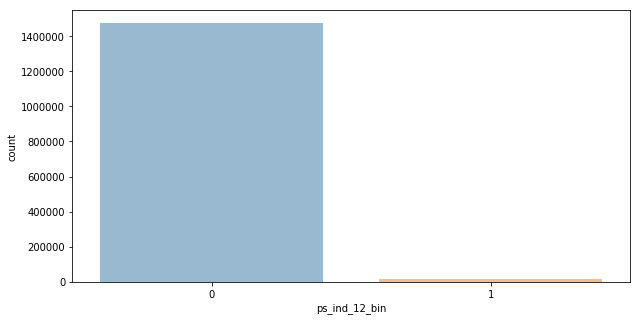

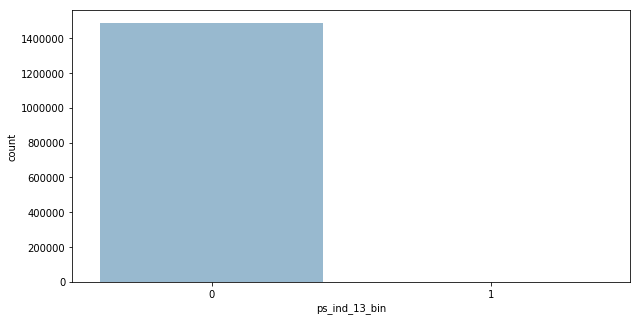

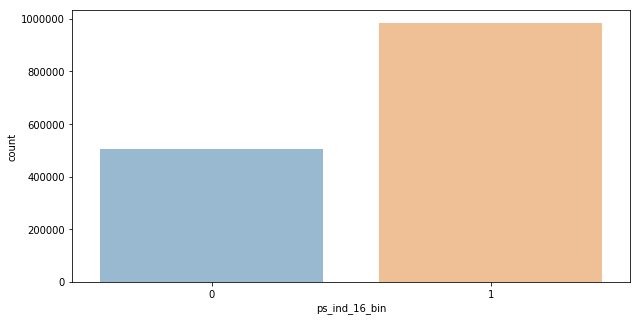

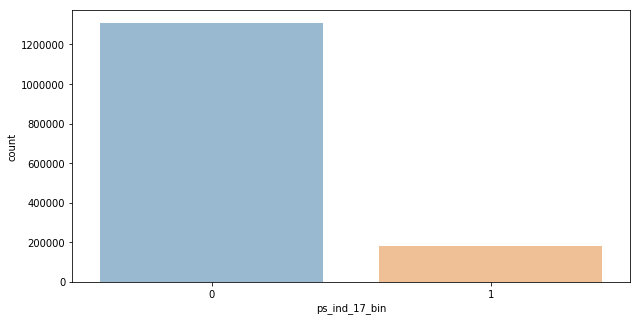

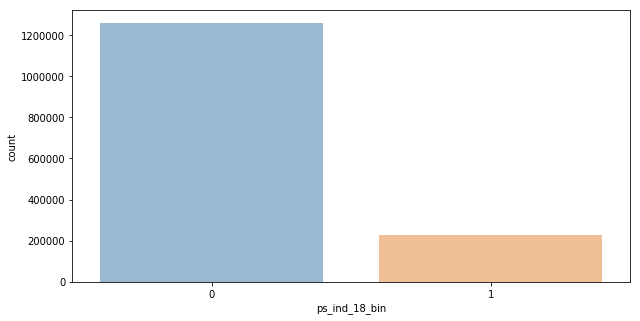

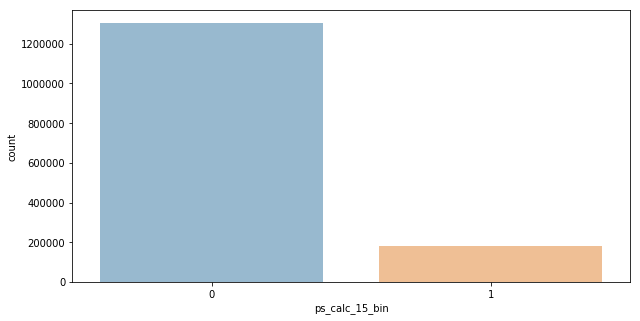

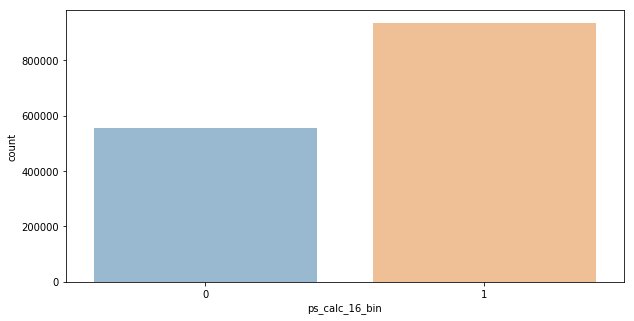

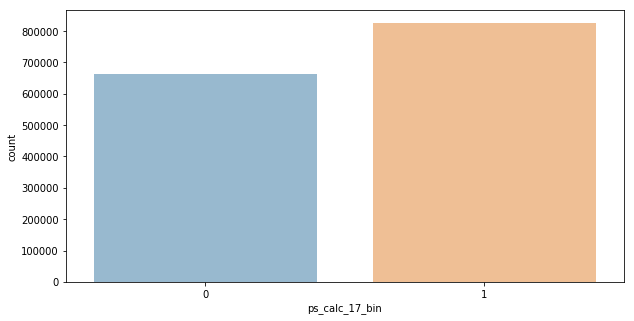

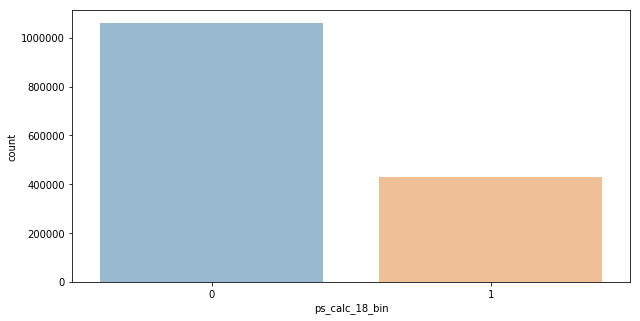

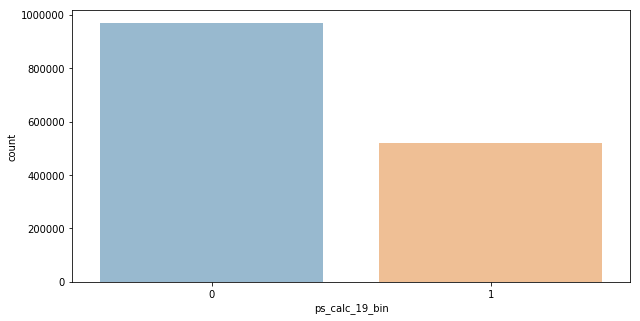

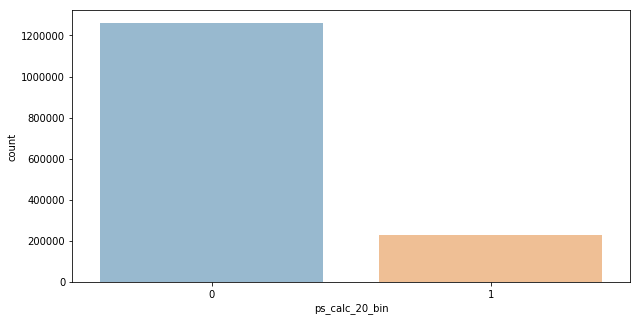

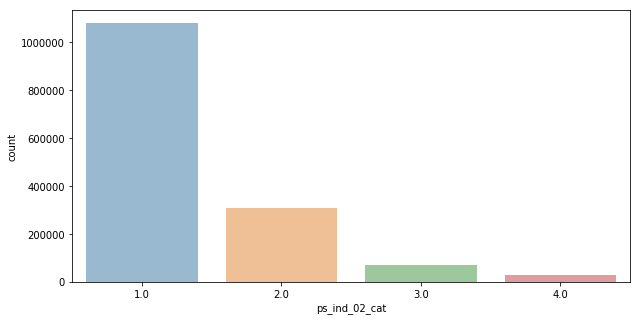

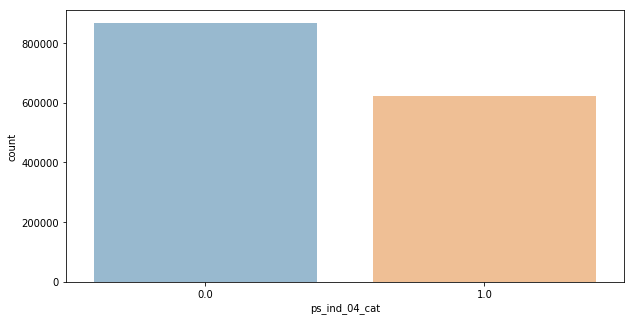

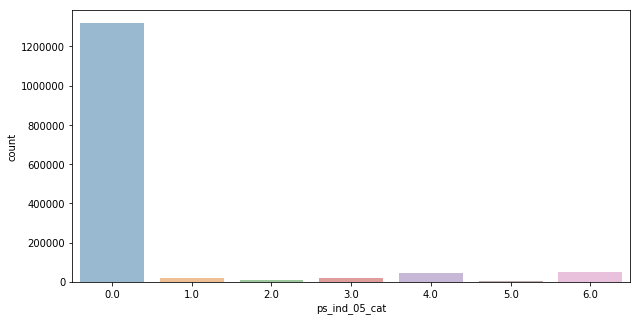

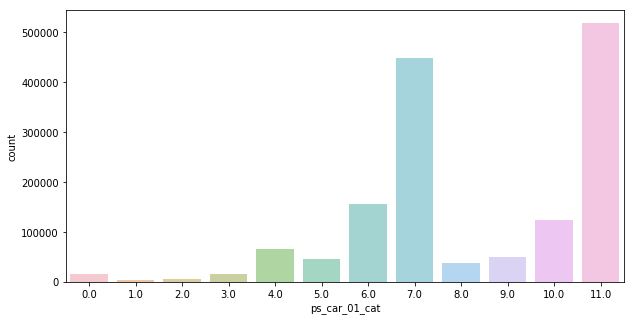

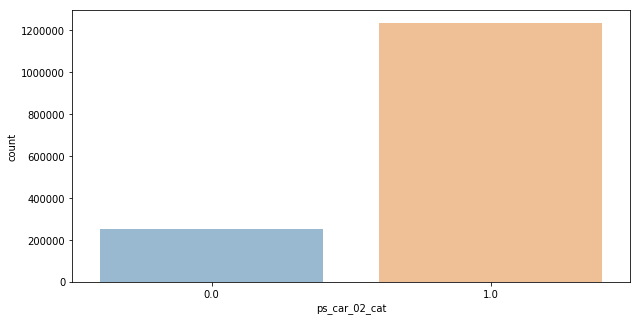

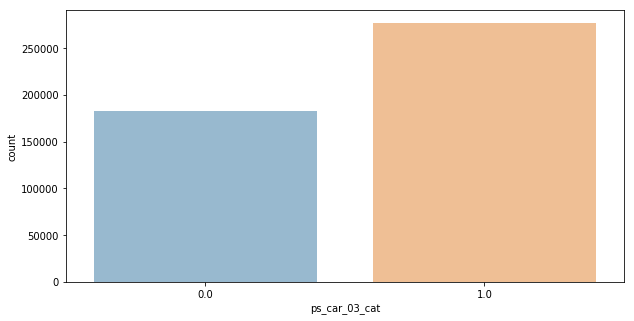

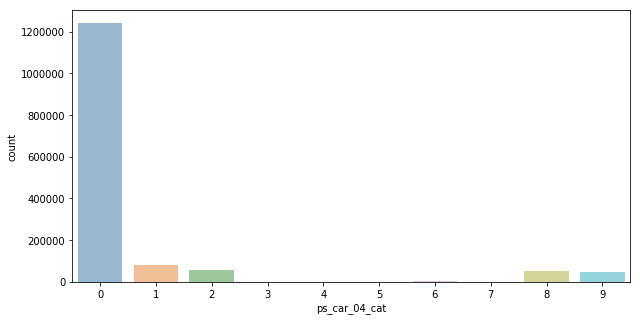

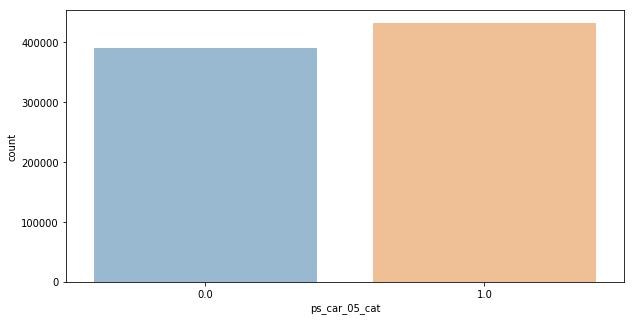

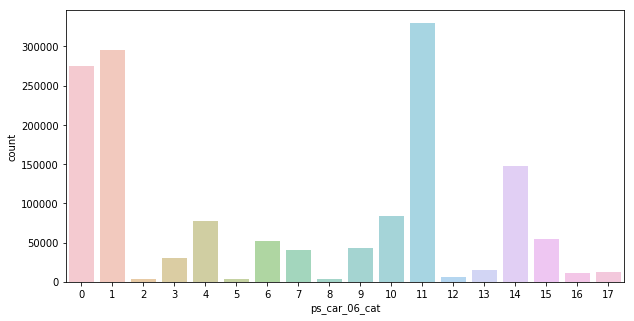

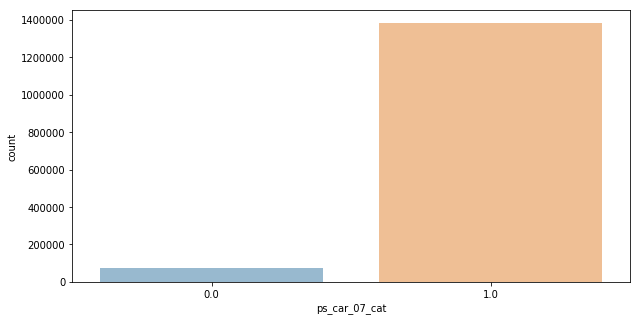

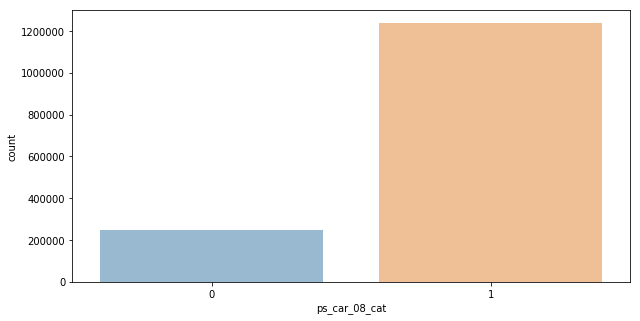

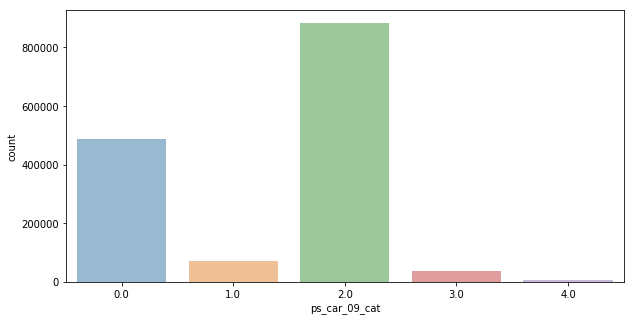

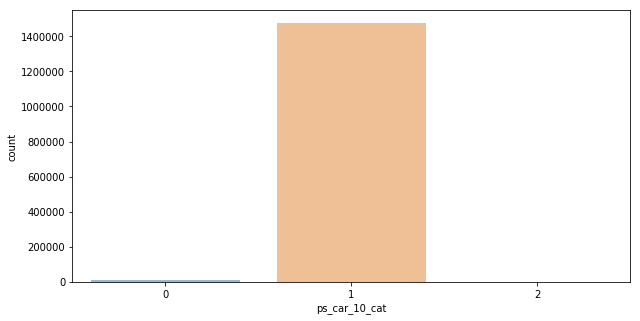

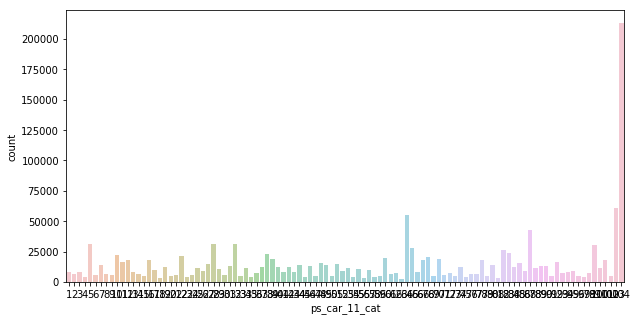

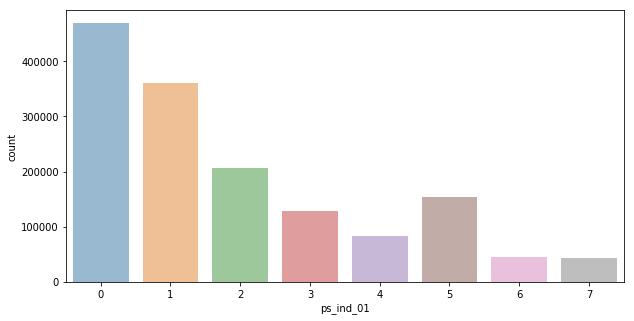

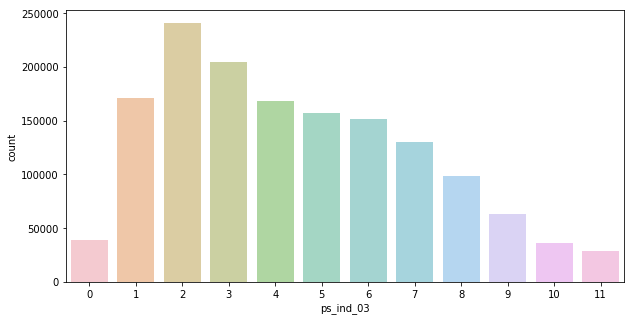

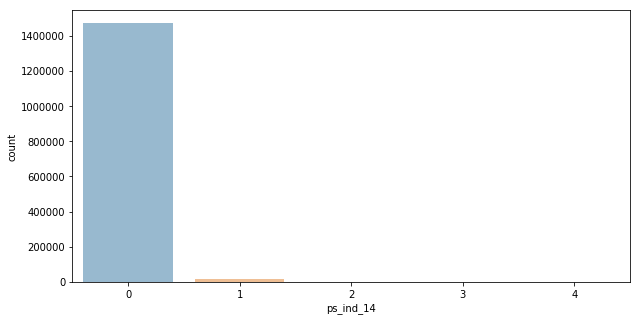

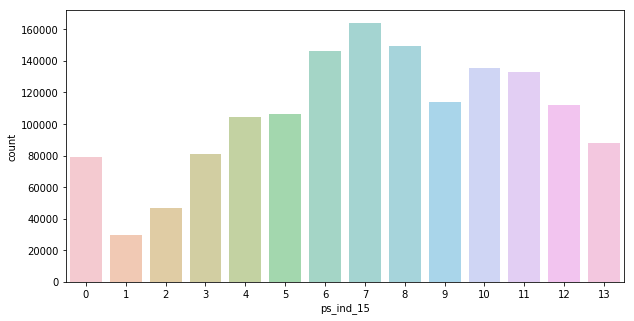

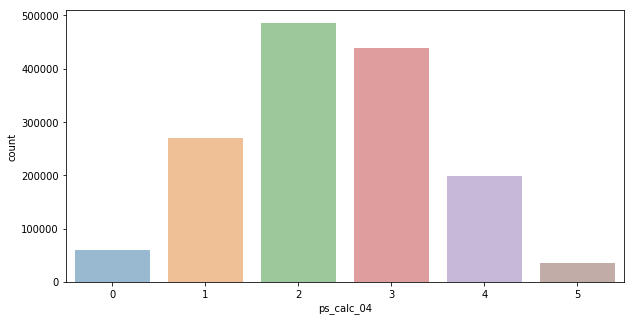

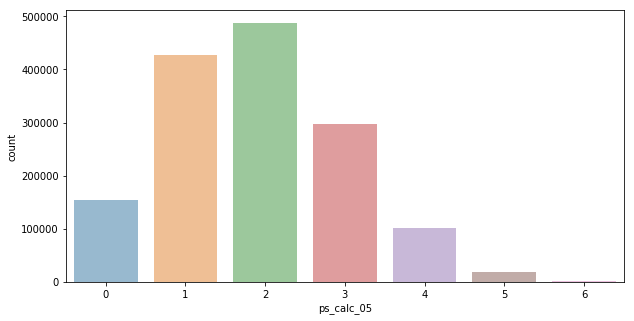

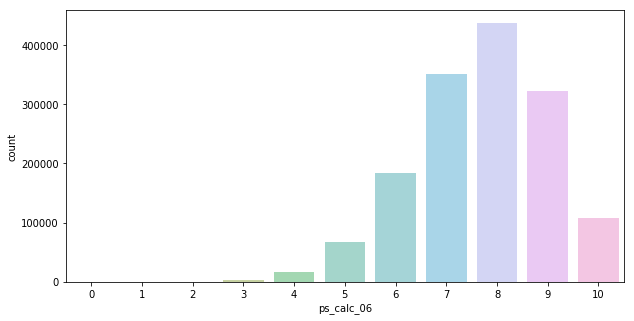

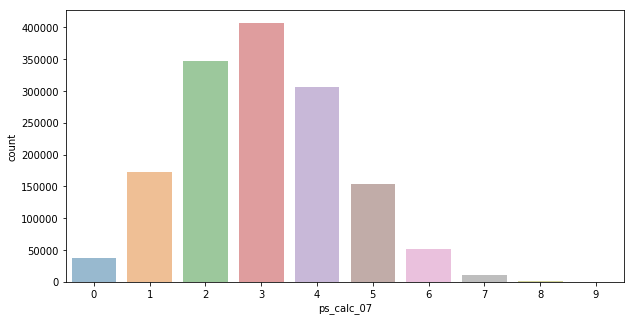

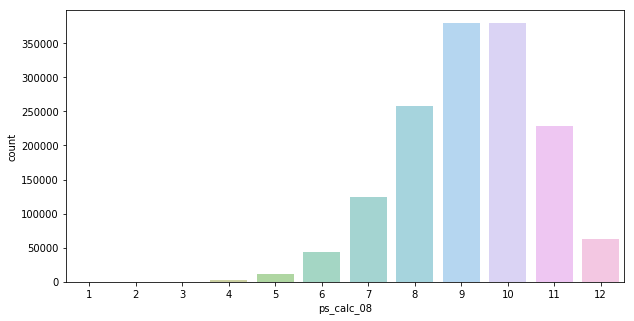

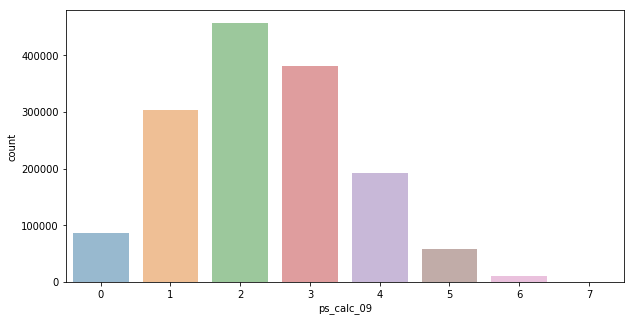

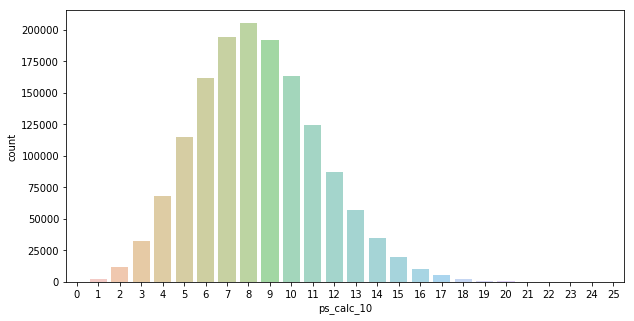

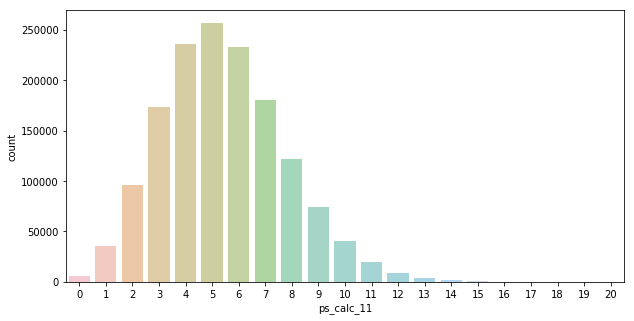

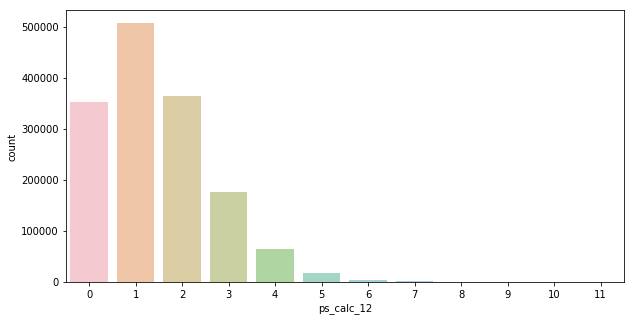

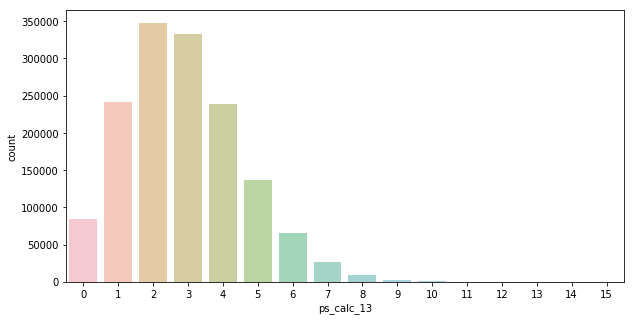

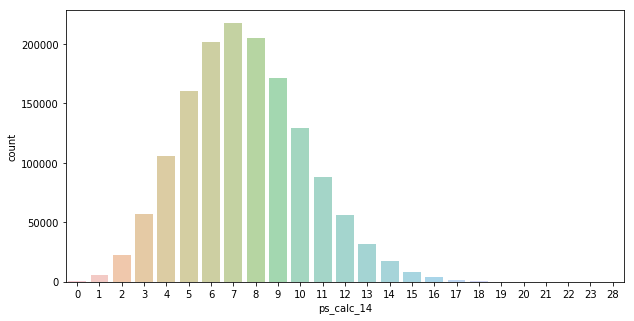

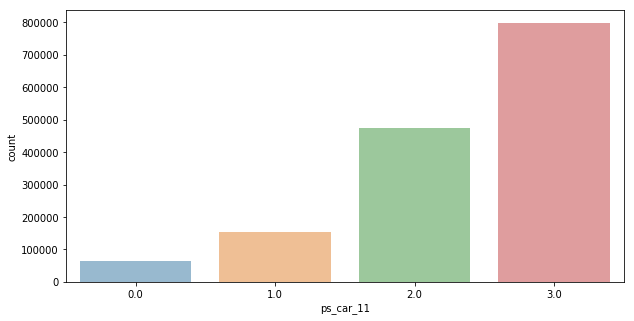

In [6]:
# 1-5 단일 변수를 히스토그램으로 시각화\
# '변수의 분포를 이해'하는게 가장 큰 목적임 !!
for col in binary + category + integer: # 총 57개 그래프 생성
    bar_plot(col, df) # df는 전체 dataframe (test와 train 합쳐 진 것)

##### 단일변수 분포 히스토그램 시각화 결과    
- ps_ind_11_bin의 경우, 0의 빈도가 압도적으로 많은 편, 
- ps_car_01_cat의 경우, 총 12개의 고유값 중 7.0과 11.0값의 빈도가 높게 나오고
- ps_ind_02_cat의 경우 1.0값이 가장 빈도가 높고, 이후 빈도는 계속 줄어든다.
- ps_calc_06과 ps_calc_07 변수는 정규 분포와 같은 분포를 보이고
- ps_ind_01과 ps_ind_03은 한쪽으로 쏠려 있는 분포를 보인다.
- ps_calc_01, ps_calc_02는 균등분포를 보이고있고,
- ps_reg_01, ps_reg_02 변수는 한쪽으로 쏠려 있다.

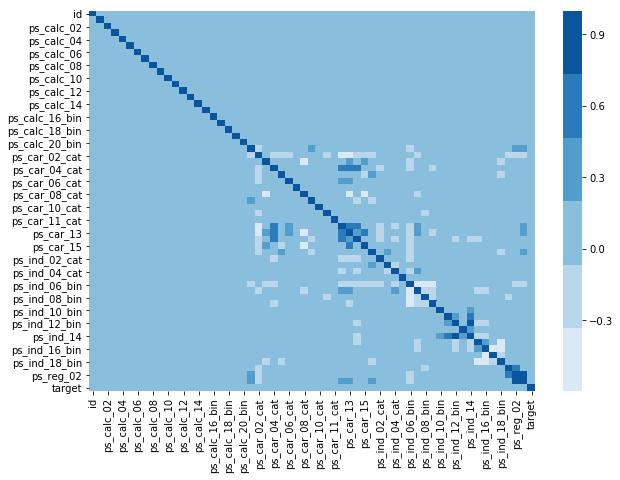

In [7]:
# 1-6. 변수간 상관관계 Heat Map 시각화
# 상관관계가 너무 높은 두 변수를 하나의 모델에 넣게되면 안좋음.
# 전체 데이터에 대한 상관관계 HeatMap 시각화
corr = df.corr() # 상관관계
cmap = sns.color_palette("Blues")
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(corr, cmap=cmap)

##### 변수간 상관관계 히트맵 시각화 결과
- 대부분의 변수간의 상관관계가 매우 낮음.
- ps_ind_14와 ps_ind_12_bin 두 변수가 0.89의 높은 상관관계를 보유하고 있고
- 그 외 나머지는 0.5 ~ 0.6 수준의 상관관계를 가진다.
- 일반적으로 0.95이상의 상관관계를 가질 경우, 변수 하나를 제거함. -> 이유인즉 변수가 중복영향을 미치는 것처럼 보이므로 ㅇㅇ

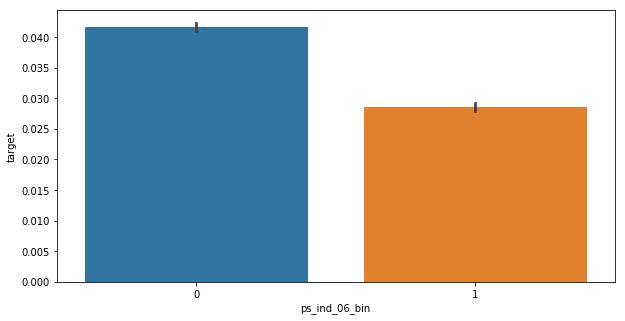

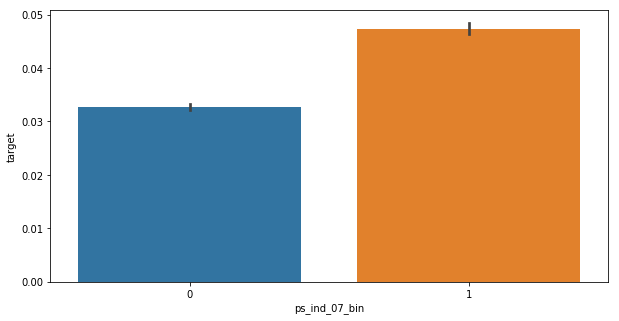

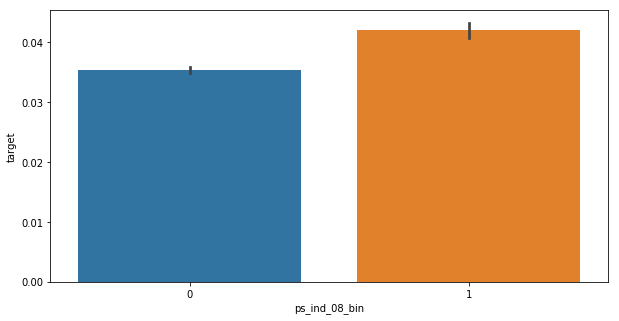

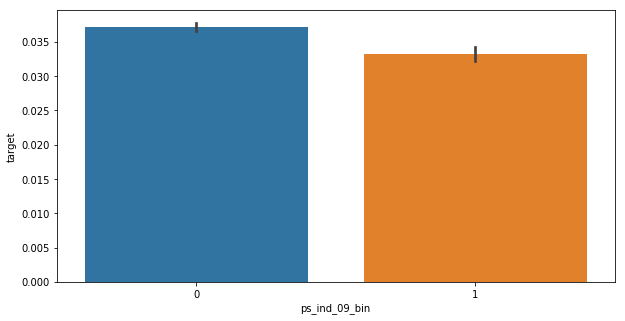

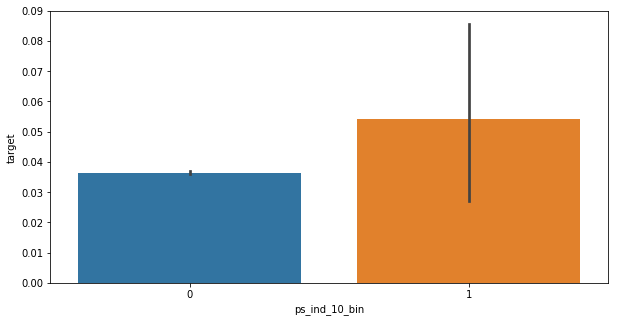

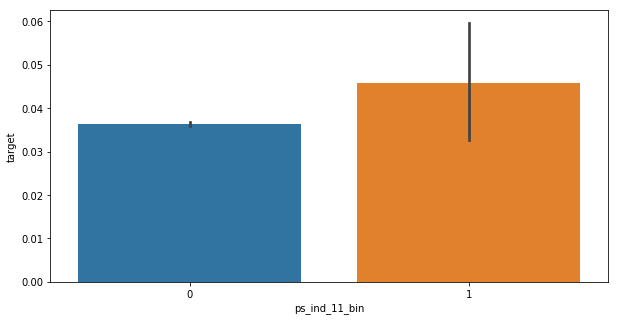

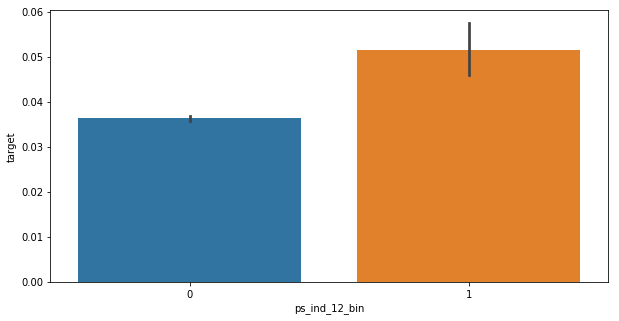

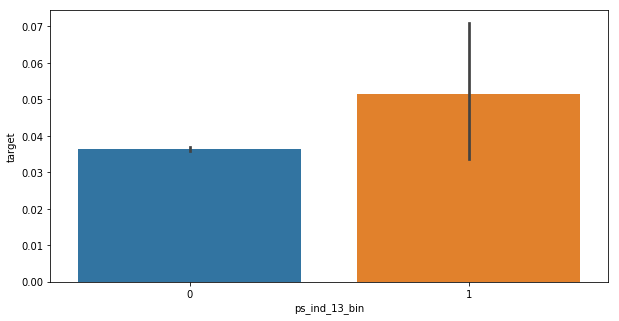

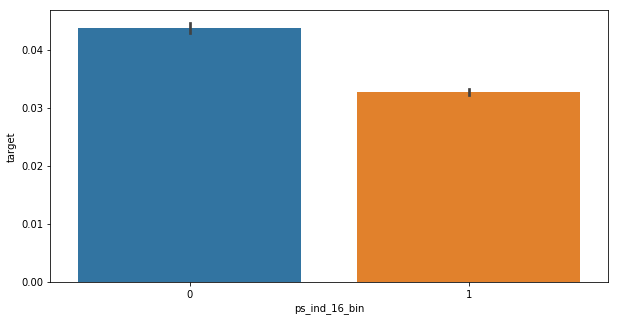

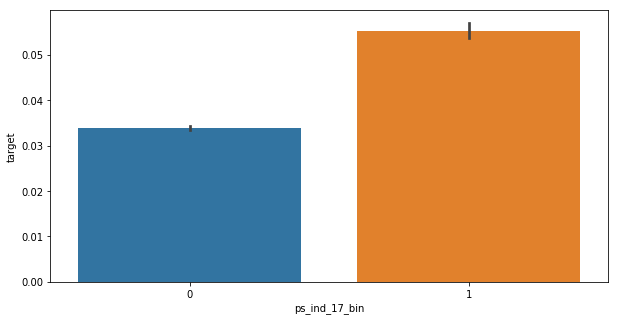

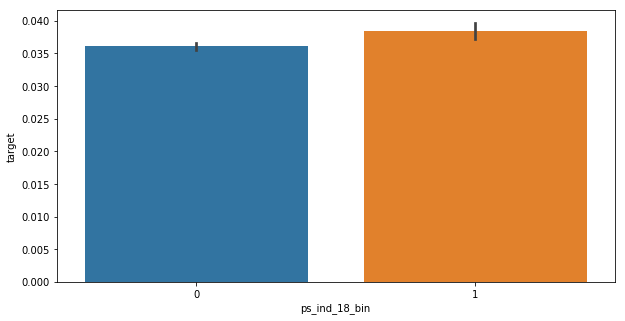

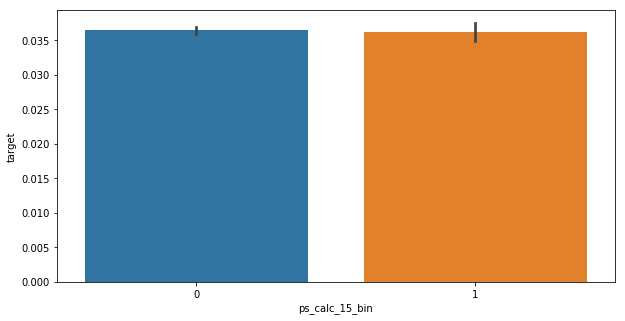

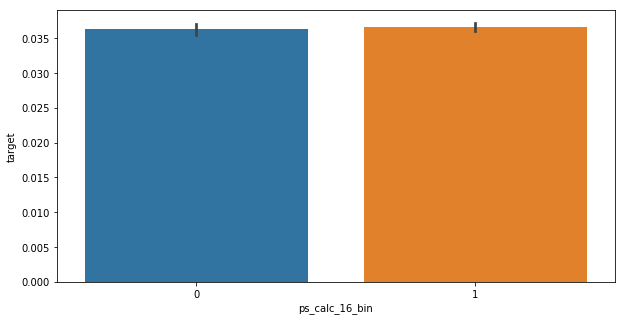

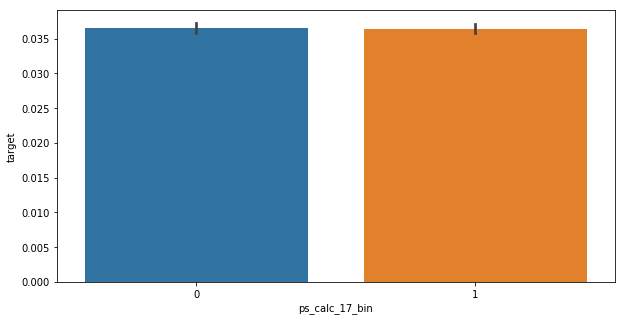

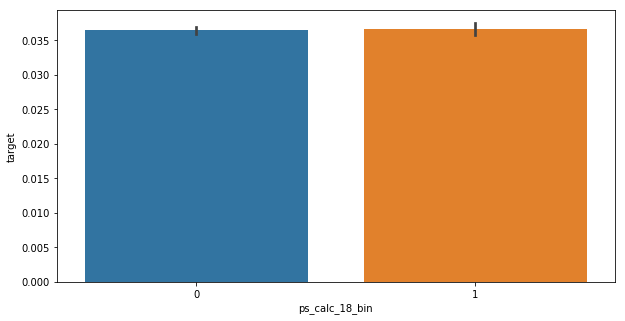

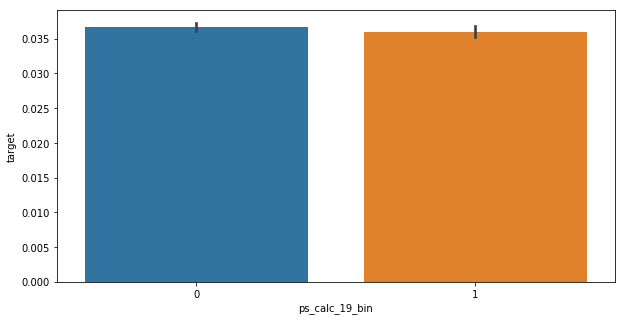

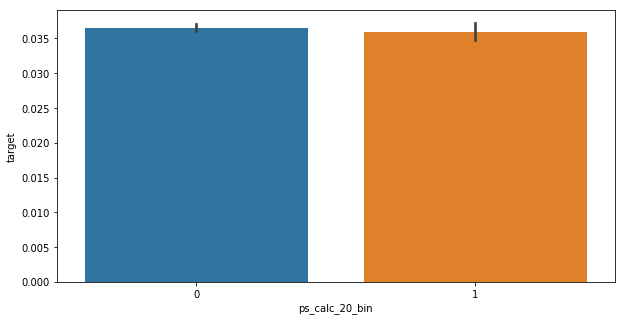

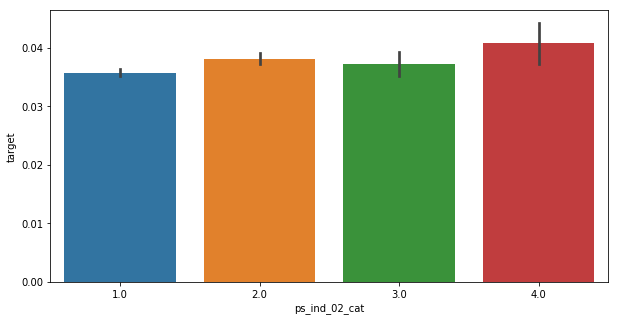

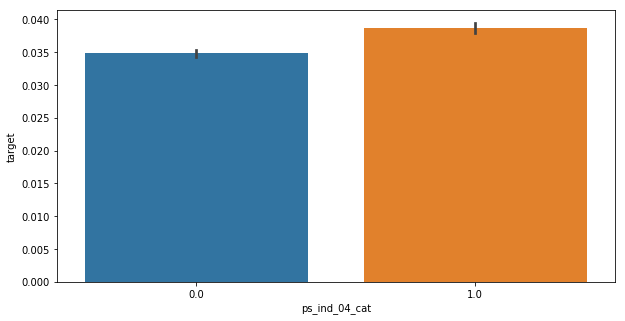

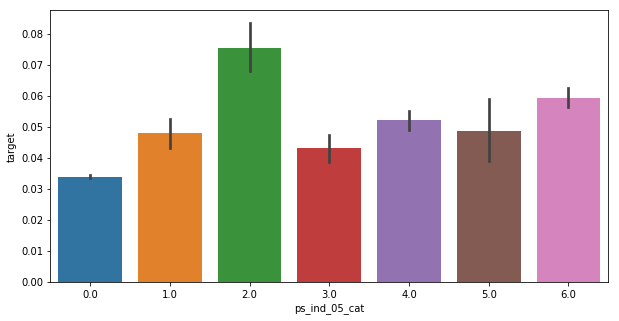

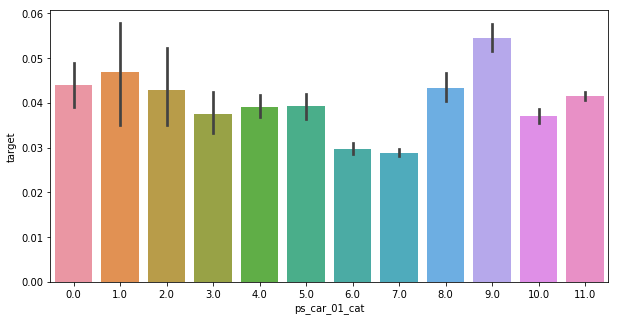

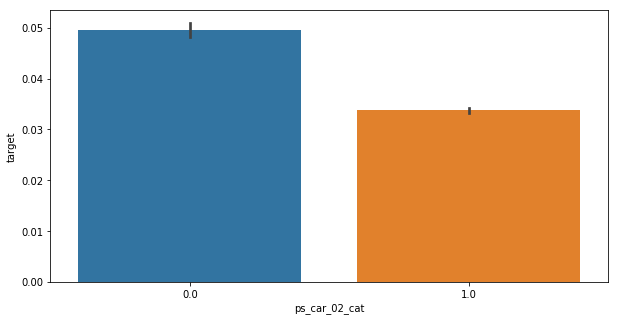

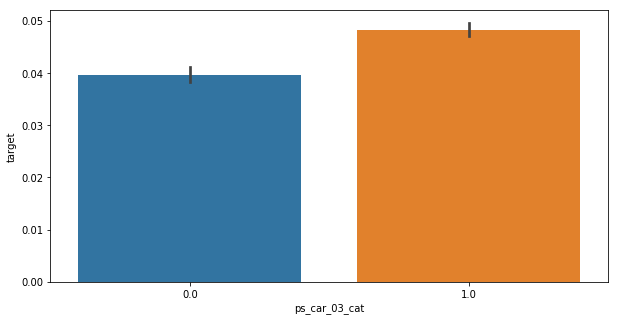

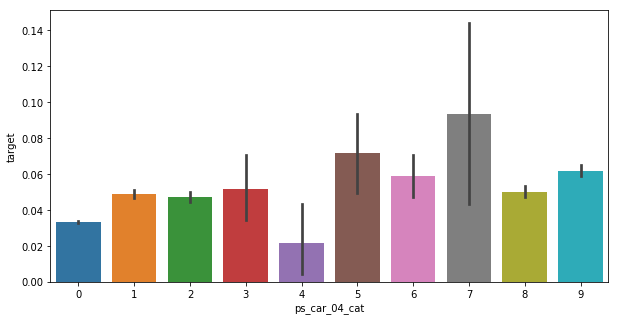

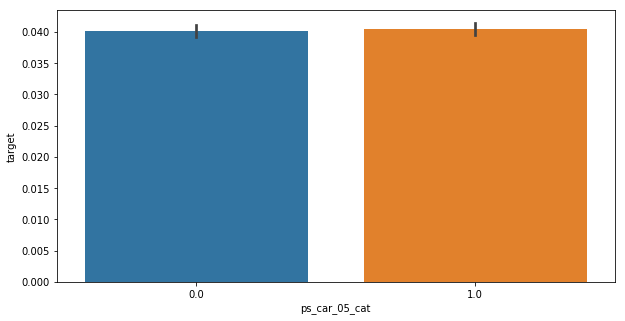

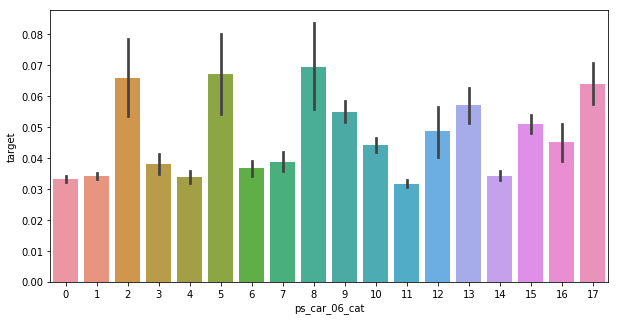

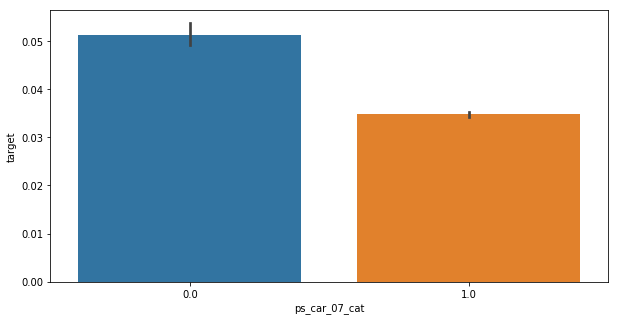

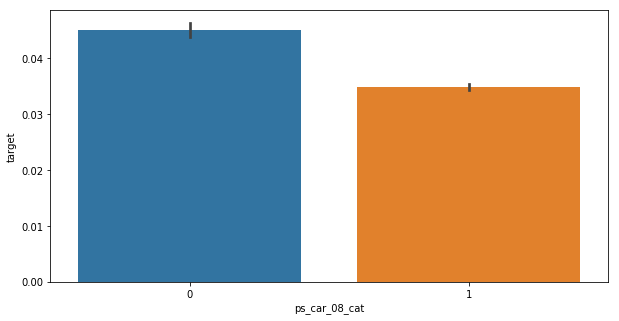

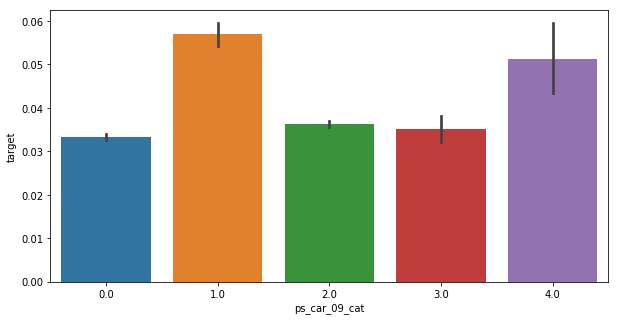

In [ ]:
# 1-7. 단일변수 vs 타겟변수
# 단일변수의 고유값별로 타겟 변수의 비율은 변수들의 예측능력을 가늠하기 위한 시각화
# 변수 예측 능력의 통계적 유효성을 확인하기 위해 변수의 고유값별로 95%의 신뢰구간을 함께 시각화한다.
for col in (binary + category + integer):
    bar_plot_ci(col, df)

##### 단일변수들의 타겟 변수의 비율에 대한 시각화
- ps_ind_16_bin, ps_ind_06_bin 두 변수는 이진 변수의 갑에 따라 타겟 변수의 비율이 달라, 통계적 유효성을 충분히 지닌 두 변수는 모델링 관점에서 유용한 변수라고 할 수 있다.
- ps_ind_11_bin은 평균값 기준으로는 타겟 변수의 비율이 유의미하게 달라보이지만, 통계적 유효성이 없다
- ps_calc_18_bin은 평균 타겟비율에서  차이를 찾기 어려우며, 이는 변수로써의 예측능력이 낮음을 의미한다.
- ps car_01_cat 변수는 단순 히스토그램 분포와는 달리 7.0과 11.0 에서 타겟 비율이 상대적으로 낮은 편이다.
- pa_car_01_cat 1.0, 2.0 등의 타겟 비율이 95% 신뢰 구간이 넓이 변수로써의 예측 능력이 월등하지는 않지만, 최소한 6.9, 7.0과는 통계적으로 유의미한 차이를 보인다.
- ps_car_11_cat의 경우, 104개의 고유값이 0.02 ~ 0.08의 큰 범위의 타겟 비율을 보인다. 해당 변수도 어느 정도 예측력을 가진 변수로 보인다
- ps_car_05_cat과 ps_ind_02_cat은 통계적으로 유효한 차이를 찾기 어렵다.
- ps_calc_06, ps_calc_07 두 변수는 특정 값에서으 ㅣ타겟 비율이 95% 신뢰 구간이 너무 광범위하여 변수로써의 예측 능력이 많이 떨어진다. 
- ps_ind_01, ps_ind_03 두 변수는 고유값별로 95% 신뢰 구간이 군집화 되고 있는 것으로 보아, 어느 정도 예측능력을 보유하고 있는 것으로 보인다.

##### => 즉 57개의 변수 중 단일 변수 기준으로 유의미한 예측 능력을 보유하고 있는 변수는 아래 변수들이다.

- 단일 변수별 타겟 비율 95% 신뢰 구간 분석을 통해 확인한 유의미한 변수 목록
- ps_ind_06_bin, ps_ind_07_bin, ps_ind_08_bin, ps_ind_09_bin
- ps_ind_12_bin, ps_ind_16_bin, ps_ind_17_bin, ps_ind_18_bin
- ps_ind_04_cat, ps_ind_05_cat, ps_car_01_cat, ps_car_02_cat
- ps_car_03_cat, ps_car_04_cat, ps_car_06_cat, ps_car_07_cat, 
- ps_car_08_cat, ps_car_09_cat, ps_car_11_cat
- ps_ind_01, ps_ind_3, ps_ind_15, ps_car_11 
##### => 총 23개

### 훈련데이터 vs 테스트 데이터는 매우 중요함
- 머신러닝 모델은 주어진 훈련 데이터의 분포를 학습하기 때문에, 두 데이터의 분포가 심각하게 다를 경우, 훈련 데이터에서의 학습 내용은 무용지물이기 때문.
- 예측력이 높은 변수를 선별하였다고 해도, 훈련 데이터에서만 높은 예측력을 보이고, 테스트 데이터에서 해당 변수의 빈도가 너무 낮아, 최종적으로 좋은 결과로 이어지지 못할 수 도 있다.

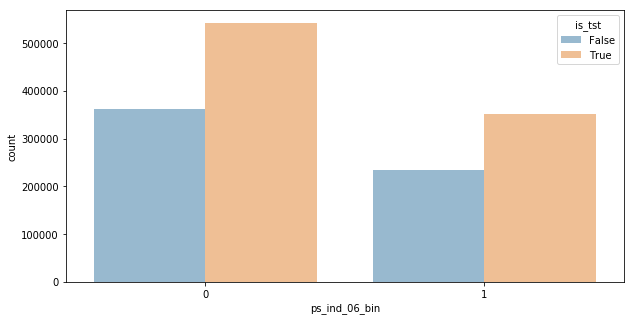

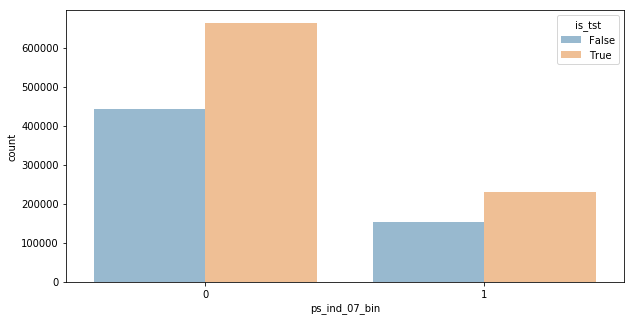

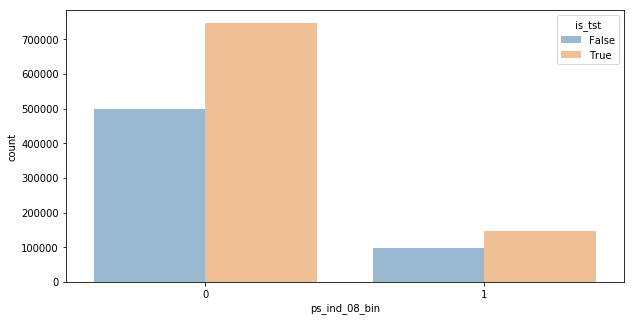

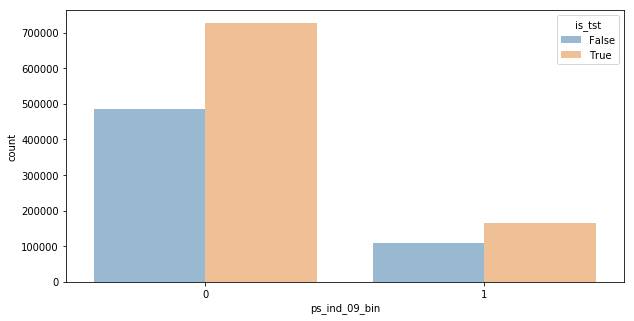

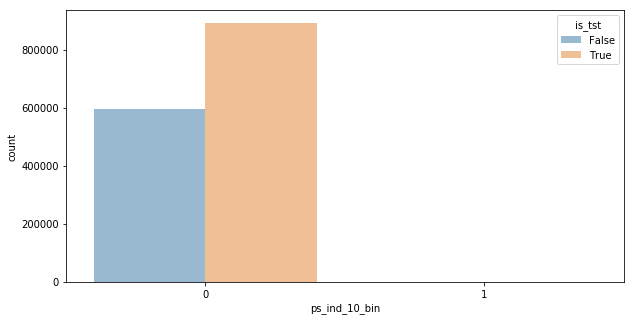

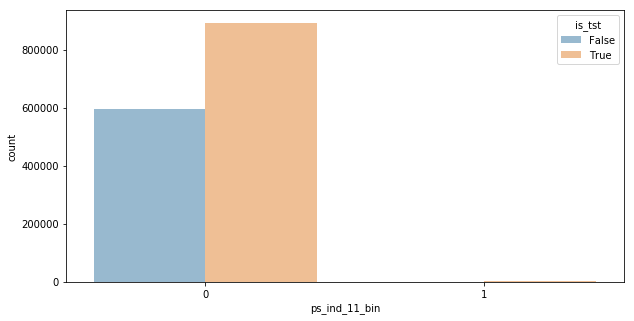

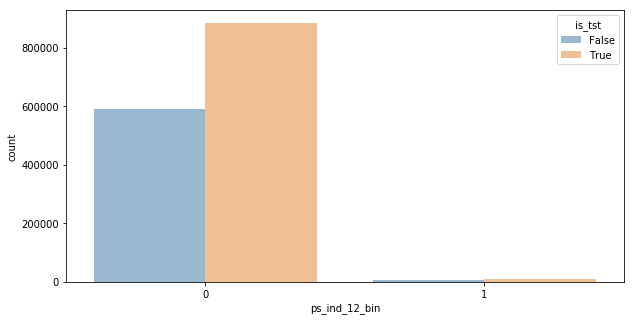

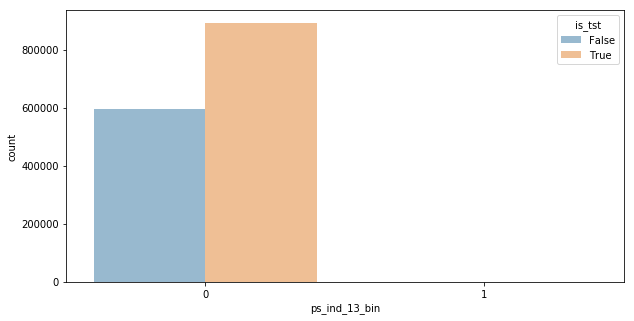

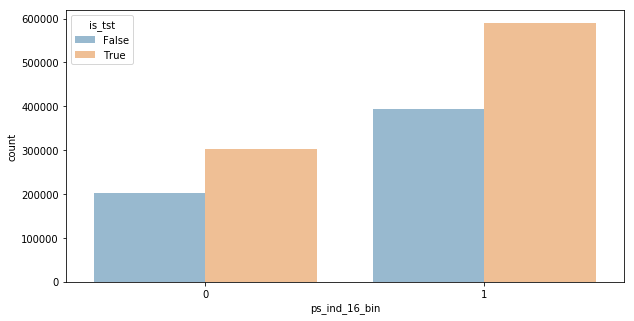

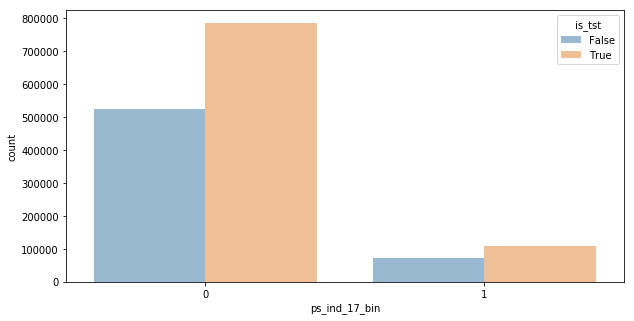

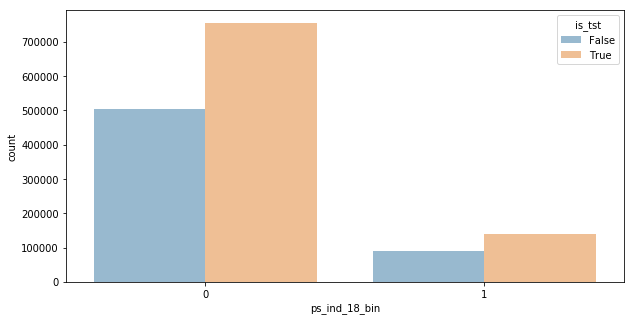

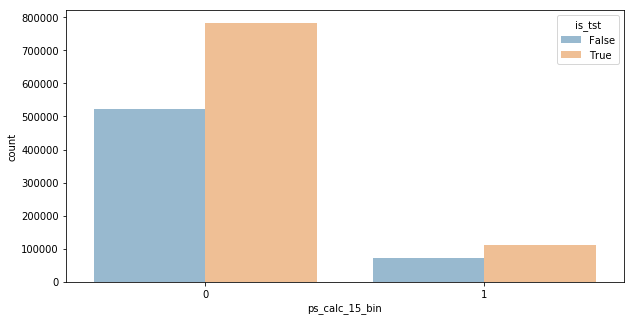

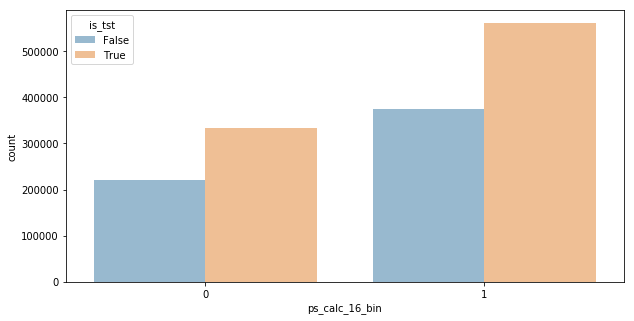

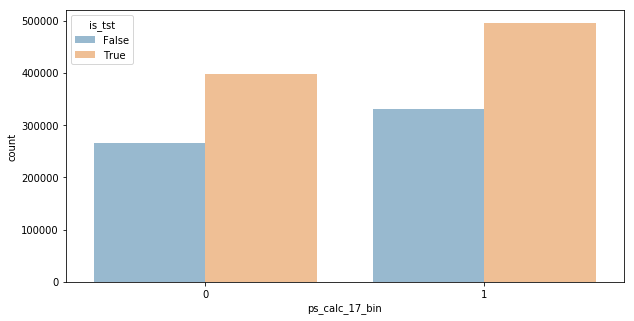

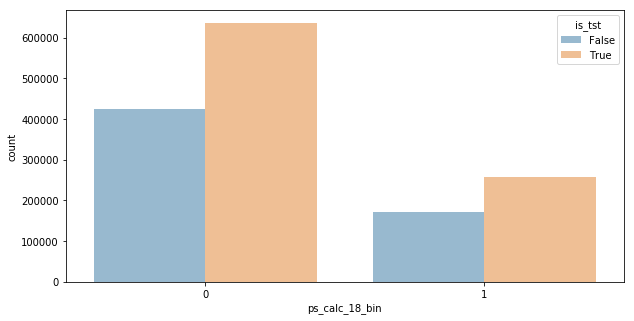

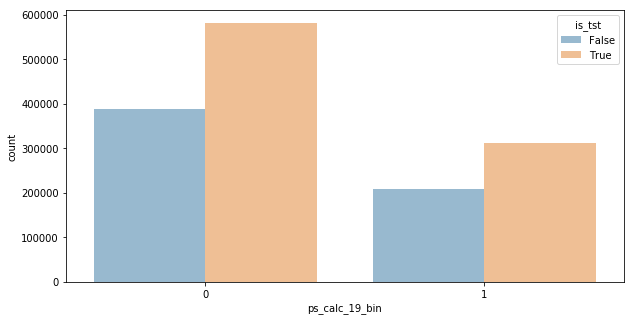

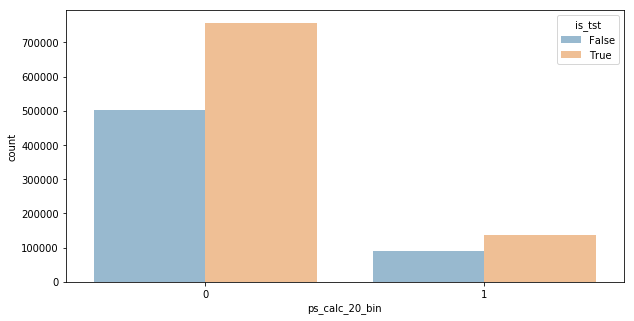

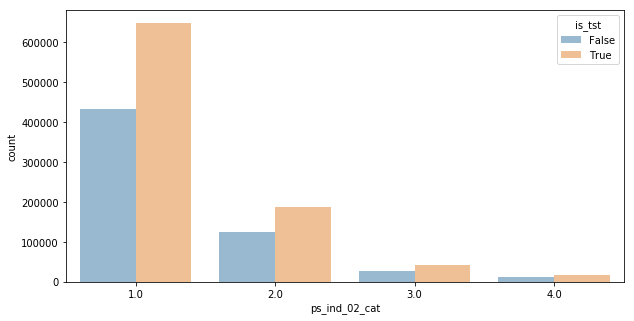

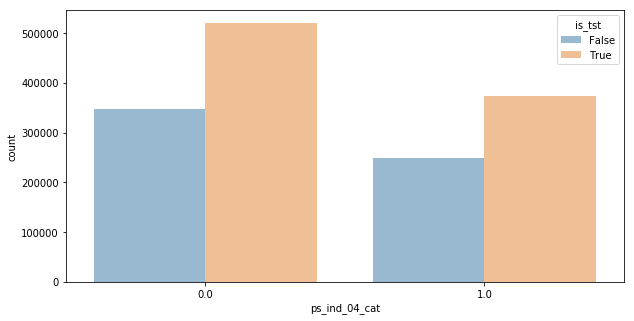

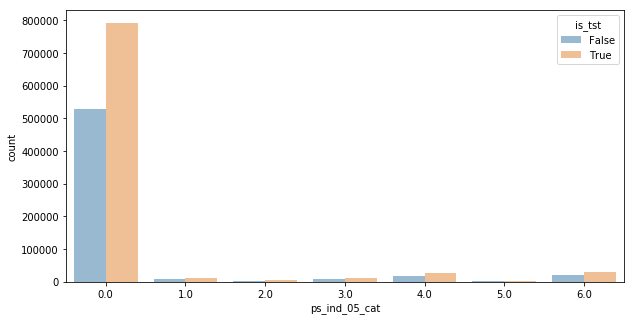

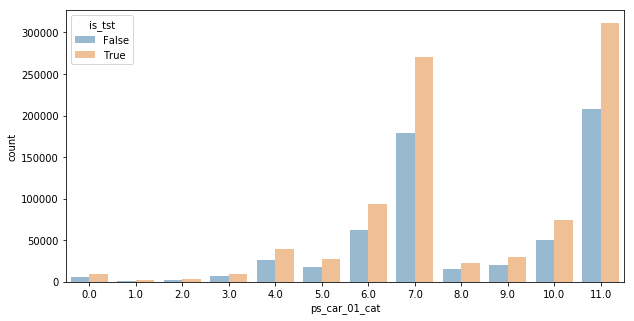

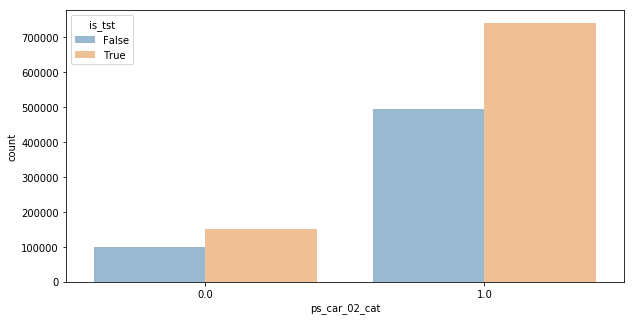

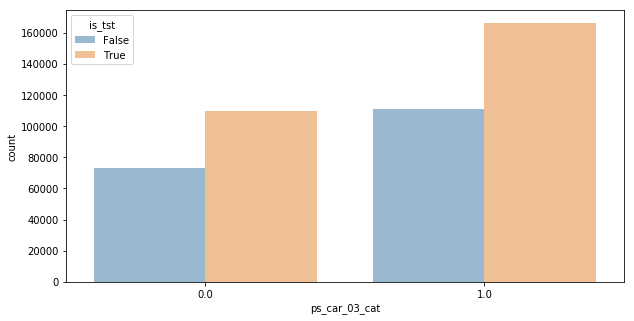

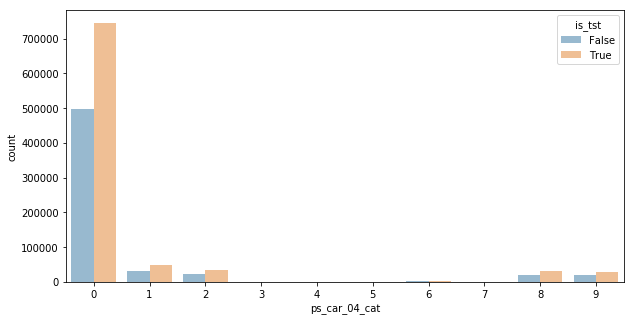

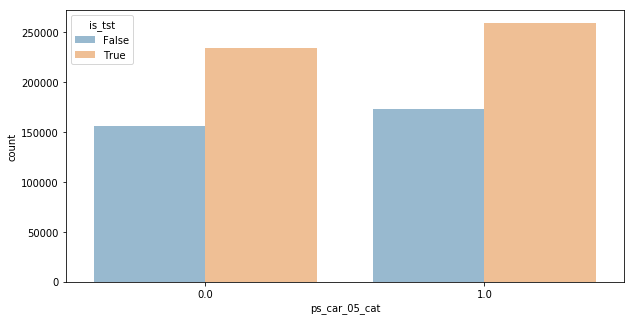

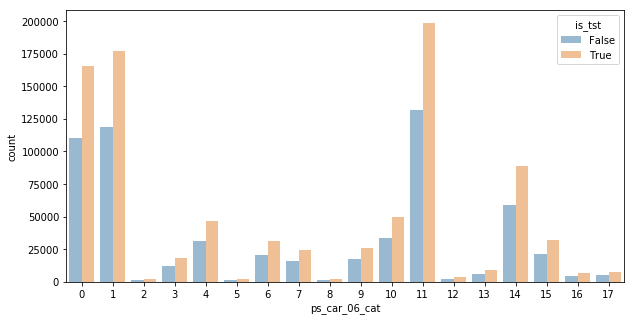

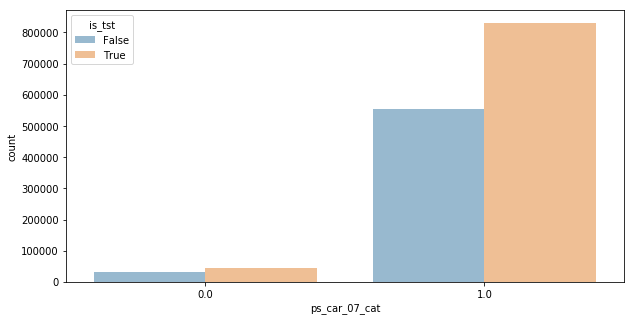

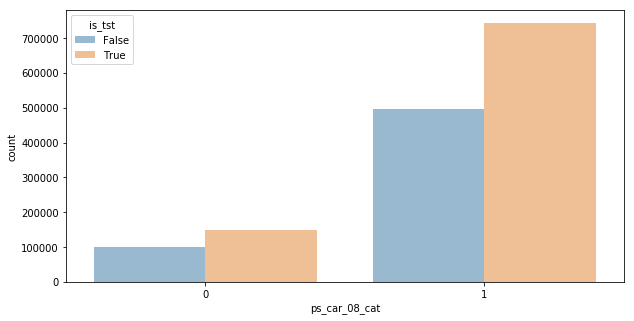

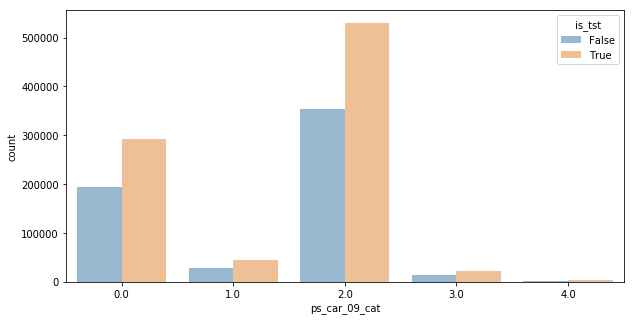

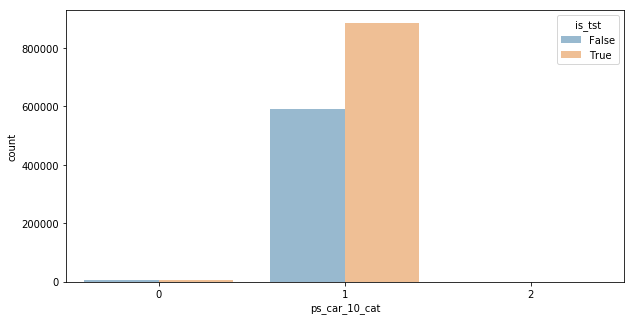

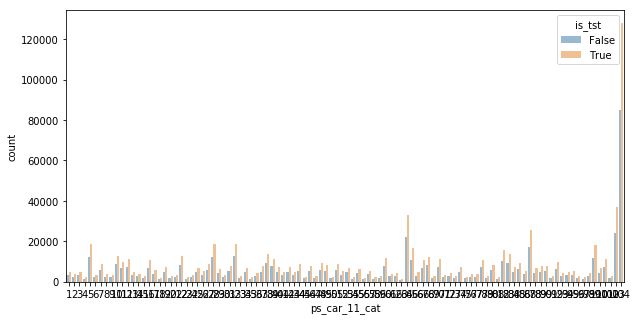

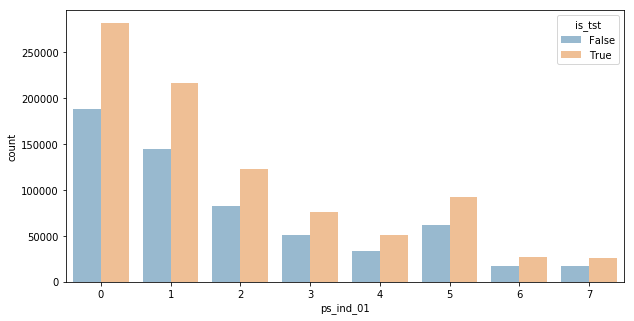

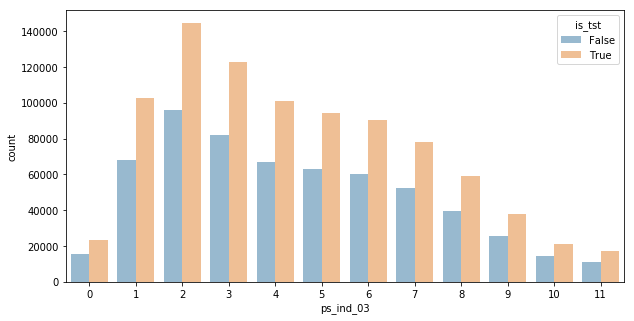

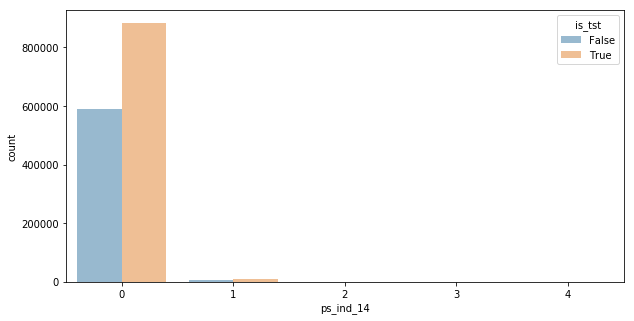

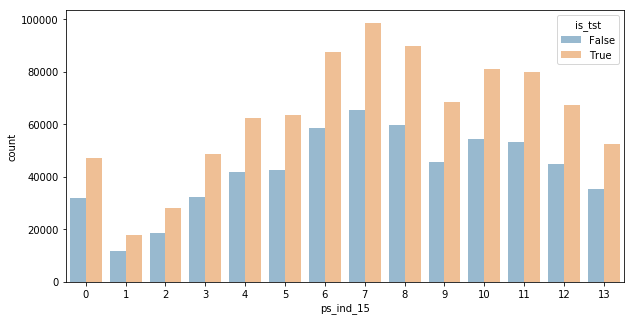

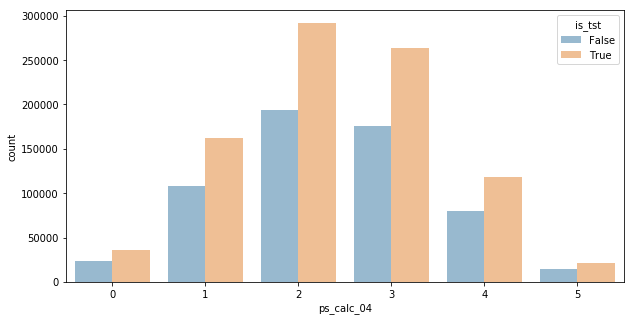

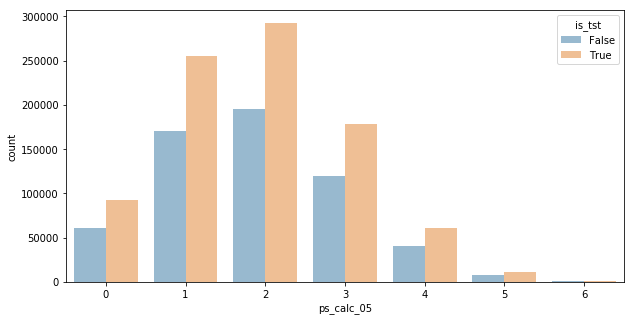

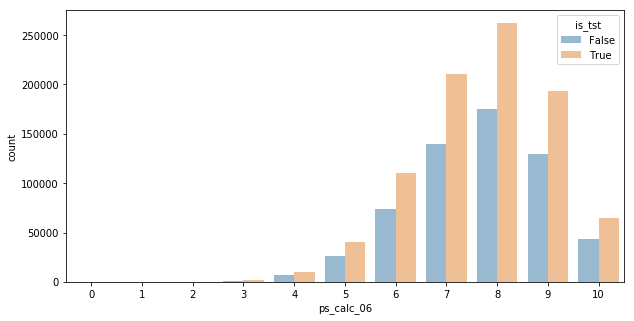

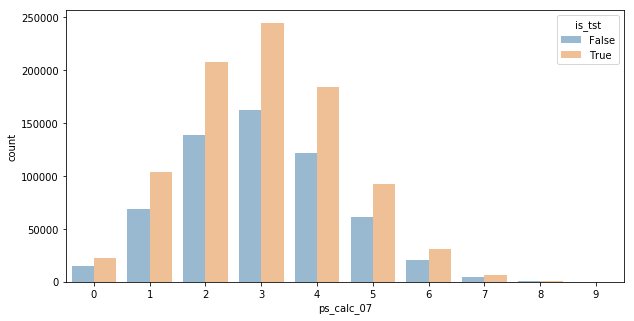

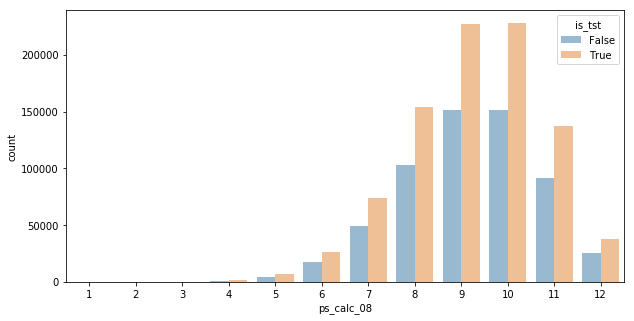

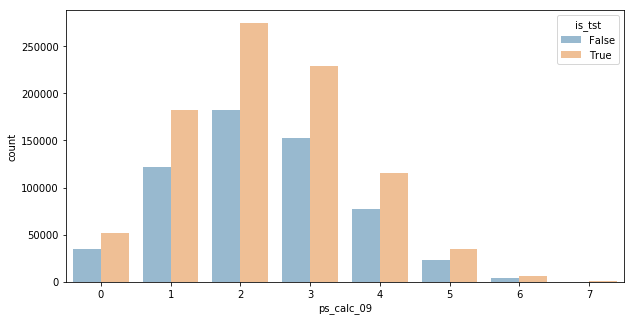

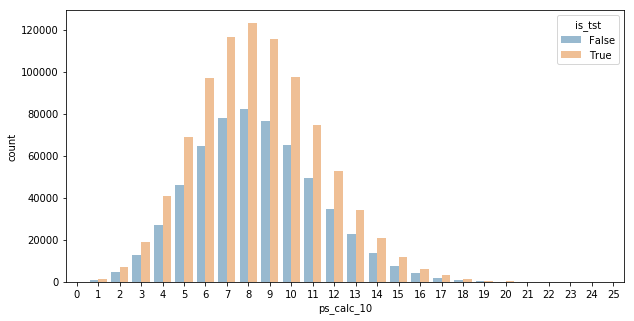

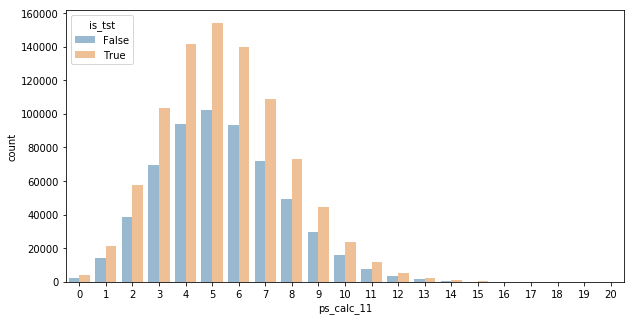

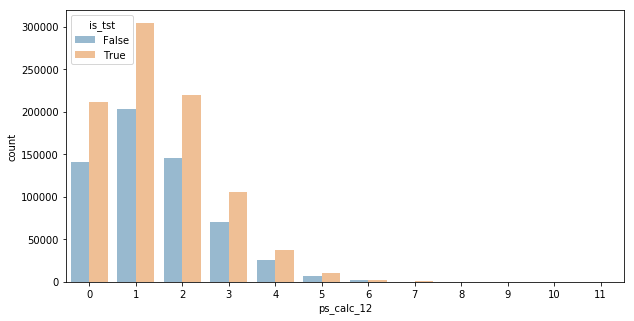

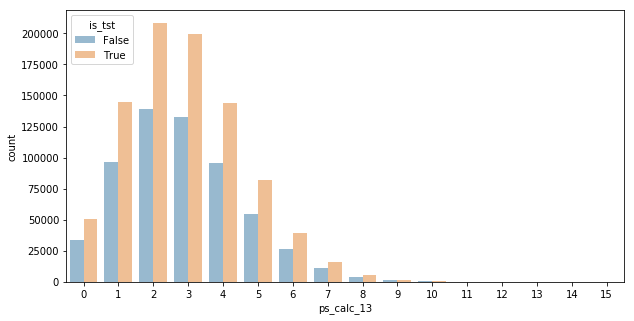

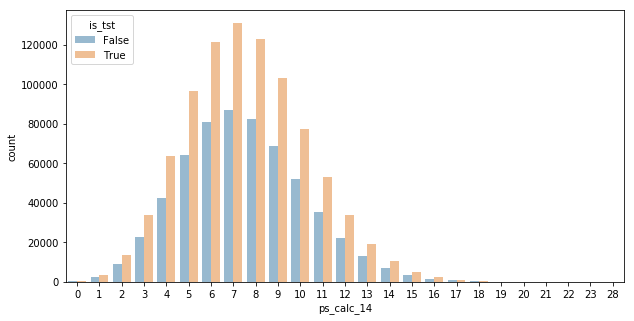

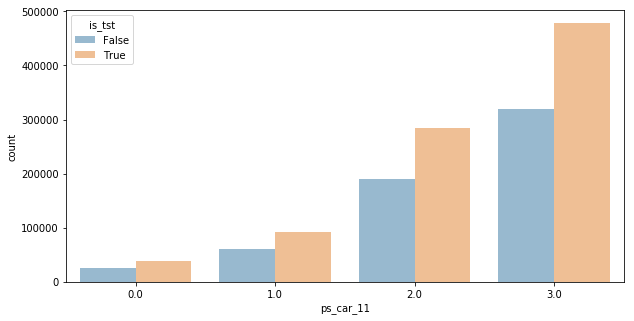

In [8]:
# 1-8 테스트 데이터를 구별하기 위한 'is_tst' 변수 생성
# 테스트 데이터틑 훈련 데이터의 1.5배인데, 892817/595212
# 훈련 데이터와 테스트 데이터의 단일 변수 히스토그램의 결과가 1.5배 비율을 유지한다면 훈련 데이터와 테스트 데이터의 분포가 서로 유사하다고 가정 할 수 있다.
df['is_tst'] = df['target'].isnull()
for col in binary + category + integer:
    bar_plot(col, df, 'is_tst')


##### ==> 비교 결과 수치형, 범주형 데이터의 분포는 비슷함.

### 최종 결과
- (1) 57개의 변수가 모두 익명화가 되어있고, 변수명을 통하여 주최자가 데이터를 총 4개 ['ind', 'calc', 'car', 'reg']의 그룹으로 변수를 군집하였음 (이진, 범주형, 정수형, 소수형)
- (2) 단일 변수에 대한 히스토그램 시각화를 통해 데이터의 분포 눈으로 확인
- (3) 상관관계 분석 결과, 주최자의 섬세한 전처리 과정으로 인해 정보력이 아예 없는 상수 값 혹은 0.95 이상의 높은 상관관계를 가지는 중복 변수 등은 존재하지 않았음.
- (4) 변수의 예측 능력을 가늠하기 위한 변수 고유값별 타겟 변수의 비율을 신뢰구간 95%와 함께 분석하여 어떠한 변수들이 타겟 변수 예측 능력이 있을지 간단하게 분석 가능
- (4) 이는 파생 변수 생성 및 추후 모델 분석에 유의미
- (5) 훈련데이터와 테스트 데이터 비교하여 매우 유사한 분포를 지니고 있음을 알게됨. 
- (6) 내부 교차 전략은 랜덤 K-fold 교차 검증 전략을 취하는게 안정적이다.